In [4]:
import sys

sys.path.insert(0, '..')

import os
import requests
import json
from tempfile import mkdtemp
from urllib.request import urlretrieve
import libsbml
import amici
import os
from biosimulator_processes.utils import prepare_single_ode_process_document
from biosimulator_processes.data_model.compare_data_model import ODEComparisonDocument, DocumentFactory
from biosimulator_processes import CORE
from process_bigraph import Composite, pp

In [5]:
process_name = 'copasi'
module_name = f'{process_name}_process'
import_statement = f'biosimulator_processes.processes.{module_name}'
module_paths = module_name.split('_')
class_name = module_paths[0].replace(module_name[0], module_name[0].upper())
class_name += module_paths[1].replace(module_paths[1][0], module_paths[1][0].upper())


class_name, module_paths[1][0].upper()

('CopasiProcess', 'P')

In [6]:
module = __import__(
    import_statement, fromlist=[class_name])
# Get the class from the module
bigraph_class = getattr(module, class_name)

In [7]:
process = bigraph_class(config={'model': {'model_source': 'BIOMD0000000630'}})

found a biomodel id


In [8]:
# Step 1: Define the input parameters of the api method

biomodel_id = 'BIOMD0000000630'
sbml_dirpath = '../biosimulator_processes/model_files/sbml'
model_fp = os.path.join(sbml_dirpath, f'{biomodel_id}_url.xml')
species_context = 'concentrations'
species_port_name = f'floating_species_{species_context}'
species_store = [f'floating_species_{species_context}_store']
duration = 30
n_steps = 42
simulators = ['copasi', 'tellurium']

In [9]:
# Step 2: Define a simple function that encapsulates that which is defined in the rest of the workflow

def generate_ode_verification(biomodel_id, dur) -> dict:
    compare = {
        'compare_ode': {
                '_type': 'step',
                  'address': 'local:compare_ode_step',
                  'config': {'biomodel_id': biomodel_id, 'duration': dur},
                  'inputs': {},
                  'outputs': {
                    'comparison_data': ['comparison_store']
                }
        },
        'verification_data': {
                 '_type': 'step',
                  'address': 'local:ram-emitter',
                  'config': {
                      'emit': {
                          'comparison_data': 'tree[any]'
                      }
                  },
                  'inputs': {
                      'comparison_data': ['comparison_store']
                  }
        }
    }
    
    
    wf = Composite(config={'state': compare}, core=CORE)
    wf.run(1)
    comparison_results = wf.gather_results()
    return comparison_results, wf

In [10]:
# Step 3: View the results. TODO: Add RMSE here.

verification_results, wf = generate_ode_verification(biomodel_id, duration)

pp(verification_results)

2024-05-16 07:34:47.707 - amici.sbml_import - INFO - Finished importing SBML                         (2.75E-02s)
2024-05-16 07:34:47.730 - amici.sbml_import - INFO - Finished processing SBML observables            (2.15E-02s)
2024-05-16 07:34:47.733 - amici.sbml_import - INFO - Finished processing SBML event observables      (6.25E-07s)
2024-05-16 07:34:47.754 - amici.de_model - INFO - Finished computing xdot                            (2.41E-03s)
2024-05-16 07:34:47.758 - amici.de_model - INFO - Finished computing x0                              (1.39E-03s)
2024-05-16 07:34:47.764 - amici.de_model - INFO - Finished computing w                               (4.87E-03s)


found a filepath


2024-05-16 07:34:48.150 - amici.de_export - INFO - Finished generating cpp code                      (3.82E-01s)
2024-05-16 07:34:58.009 - amici.de_export - INFO - Finished compiling cpp code                       (9.86E+00s)
/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/biosimulator_processes/processes/copasi_process.py:205: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



{ ('verification_data',): [ { 'comparison_data': { ('emitter',): [ { 'amici_simple_floating_species_concentrations': { 'plasmin': 0.0,
                                                                                                                       'plasminogen': 0.0,
                                                                                                                       'single intact chain urokinase-type plasminogen activator': 0.0,
                                                                                                                       'two-chain urokinase-type plasminogen activator': 0.0,
                                                                                                                       'x': 0.0,
                                                                                                                       'x-plasmin': 0.0},
                                                                     'copasi_simple_floating_species_

In [11]:
verification_results

{('verification_data',): [{'comparison_data': {('emitter',): [{'copasi_simple_floating_species_concentrations': {'plasminogen': 0.0,
       'plasmin': 0.0,
       'single intact chain urokinase-type plasminogen activator': 0.0,
       'two-chain urokinase-type plasminogen activator': 0.0,
       'x': 0.0,
       'x-plasmin': 0.0},
      'amici_simple_floating_species_concentrations': {'plasminogen': 0.0,
       'plasmin': 0.0,
       'single intact chain urokinase-type plasminogen activator': 0.0,
       'two-chain urokinase-type plasminogen activator': 0.0,
       'x': 0.0,
       'x-plasmin': 0.0},
      'tellurium_simple_floating_species_concentrations': {'species_1': 0.0,
       'species_2': 0.0,
       'species_3': 0.0,
       'species_4': 0.0},
      'time': 0.0},
     {'copasi_simple_floating_species_concentrations': {'plasminogen': 1.1758171177387002e+16,
       'plasmin': 1096150505274.1506,
       'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,

In [12]:
"""TODO: Update the input/output schema of the ODEComparatorProcess to mimic the following:

{('emitter',): [{
    'copasi': [
        {
            'floating_species_concentrations': {
                'plasminogen': 0.0,
                'plasmin': 0.0,
                'single intact chain urokinase-type plasminogen activator': 0.0,
                'two-chain urokinase-type plasminogen activator': 0.0,
                'x': 0.0,
                'x-plasmin': 0.0},
           'time': 0.0
        },
        ...
    ],
    'amici': [
        {
            'floating_species_concentrations': {
                'plasminogen': 1.1758171177387002e+16,
                'plasmin': 1096150505274.1506,
                'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,
                'two-chain urokinase-type plasminogen activator': 80249.33829510311,
                'x': 0.0,
                'x-plasmin': 0.0},
           'time': 0.0},
        },
       ...
    ]


"""

"TODO: Update the input/output schema of the ODEComparatorProcess to mimic the following:\n\n{('emitter',): [{\n    'copasi': [\n        {\n            'floating_species_concentrations': {\n                'plasminogen': 0.0,\n                'plasmin': 0.0,\n                'single intact chain urokinase-type plasminogen activator': 0.0,\n                'two-chain urokinase-type plasminogen activator': 0.0,\n                'x': 0.0,\n                'x-plasmin': 0.0},\n           'time': 0.0\n        },\n        ...\n    ],\n    'amici': [\n        {\n            'floating_species_concentrations': {\n                'plasminogen': 1.1758171177387002e+16,\n                'plasmin': 1096150505274.1506,\n                'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,\n                'two-chain urokinase-type plasminogen activator': 80249.33829510311,\n                'x': 0.0,\n                'x-plasmin': 0.0},\n           'time': 0.0},\n        },\n 

In [13]:
wf

In [14]:
wf.state.keys()

dict_keys(['compare_ode', 'verification_data', 'global_time', 'comparison_store'])

In [15]:
emitter = wf.state['verification_data']['instance']

In [16]:
emitter.history

[{'comparison_data': {('emitter',): [{'copasi_simple_floating_species_concentrations': {'plasminogen': 0.0,
      'plasmin': 0.0,
      'single intact chain urokinase-type plasminogen activator': 0.0,
      'two-chain urokinase-type plasminogen activator': 0.0,
      'x': 0.0,
      'x-plasmin': 0.0},
     'amici_simple_floating_species_concentrations': {'plasminogen': 0.0,
      'plasmin': 0.0,
      'single intact chain urokinase-type plasminogen activator': 0.0,
      'two-chain urokinase-type plasminogen activator': 0.0,
      'x': 0.0,
      'x-plasmin': 0.0},
     'tellurium_simple_floating_species_concentrations': {'species_1': 0.0,
      'species_2': 0.0,
      'species_3': 0.0,
      'species_4': 0.0},
     'time': 0.0},
    {'copasi_simple_floating_species_concentrations': {'plasminogen': 1.1758171177387002e+16,
      'plasmin': 1096150505274.1506,
      'single intact chain urokinase-type plasminogen activator': 2955755808974603.0,
      'two-chain urokinase-type plasminogen

In [17]:
wf.state['global_time']

1.0

In [18]:
outputs_1 = {
      "interval_id": 1,
      "copasi_floating_species_concentrations": {
        "plasminogen": 11758171177387002,
        "plasmin": 1096150505274.1506,
        "single intact chain urokinase-type plasminogen activator": 2955755808974603,
        "two-chain urokinase-type plasminogen activator": 80249.33829510311,
        "x": 0,
        "x-plasmin": 0
      },
      "tellurium_floating_species_concentrations": {
        "species_1": 0.009841338446759926,
        "species_2": 3.50091366956004e-7,
        "species_3": 0.003069285532211755,
        "species_4": 1.9636710780672987e-15
      },
      "amici_floating_species_concentrations": {
        "plasminogen": 0.01,
        "plasmin": 0,
        "single intact chain urokinase-type plasminogen activator": 0.002,
        "two-chain urokinase-type plasminogen activator": 0,
        "x": 0,
        "x-plasmin": 0
      },
      "time": 3
}

In [19]:
from biosimulator_processes.steps.comparator_step import generate_ode_process_comparison_matrix

species_data_index = 0

results = generate_ode_process_comparison_matrix(outputs_copasi=list(outputs_1['copasi_floating_species_concentrations'].values())[species_data_index],
                                                 outputs_amici=list(outputs_1['amici_floating_species_concentrations'].values())[species_data_index],
                                                 outputs_tellurium=list(outputs_1['tellurium_floating_species_concentrations'].values())[species_data_index])

ImportError: cannot import name 'generate_ode_process_comparison_matrix' from 'biosimulator_processes.steps.comparator_step' (/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/biosimulator_processes/steps/comparator_step.py)

In [ ]:
results

In [ ]:
from biosimulator_processes.data_model import DescriptiveArray
import numpy as np
import pandas as pd


output_copasi = DescriptiveArray(np.random.random(100), description='copasi output', process_id='simple_copasi')
output_tellurium = DescriptiveArray(np.random.random(100), description='tell output', process_id='simple_tellurium')

output_copasi.metadata, output_tellurium.metadata

In [ ]:
raw_outputs_matrix = np.stack([output_copasi, output_tellurium])

raw_outputs_matrix

In [ ]:
raw_outputs_df = pd.DataFrame(
    raw_outputs_matrix, 
    columns=[f'param_{str(n)}' for n in range(raw_outputs_matrix.shape[1])],
    index=[output_copasi.metadata['process_id'], output_tellurium.metadata['process_id']])

In [ ]:
raw_outputs_df

In [ ]:
transposed_outputs_df = raw_outputs_df.transpose()

transposed_outputs_df

In [ ]:
transposed_outputs_df.index

In [ ]:
def calc_comparison(a, b):
    return (a - b) ** 2

In [ ]:
np.random.random(3) - np.random.random(3)

In [ ]:
transposed_comparisons = dict(zip(transposed_outputs_df.index, 
                                  [calc_comparison(*output_vals) for output_vals in transposed_outputs_df.values]))

In [ ]:
for outputs in raw_outputs_matrix:
    print(outputs)

In [ ]:
transposed_comparisons

In [ ]:
comparison_data = {
    ('copasi', 'tellurium'): transposed_comparisons
}

In [ ]:
comparison_data

In [ ]:
import json 
from biosimulator_processes.data_model.compare_data_model import ODEComparisonResult


with open('/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_outputs/test_ode_comparison_object.json', 'r') as f:
    output_data_response = json.load(f)

data_config = output_data_response.copy()
data_config.pop('outputs')
data_config.pop('timestamp')
    
    
output_data = ODEComparisonResult(**data_config)

In [ ]:
def extract_unique_output_names(output_data: ODEComparisonResult) -> list[str]:   
    output_names = []
    for i, interval_output in enumerate(output_data.outputs):
        output_attributes = vars(interval_output)
        for output_attribute_key, output_value in output_attributes.items():
            if isinstance(output_value, dict):
                output_names.append(output_attribute_key)
    return list(set(output_names))
    

In [ ]:
extract_unique_output_names(output_data)

In [ ]:
from biosimulator_processes.steps.comparator_step import construct_process_interval_matrix

In [ ]:
import numpy as np
import random
import pandas as pd


output_copasi = np.array([1.3, 2.4, 4.3])
output_tellurium = np.array([1.3, 2.4, 4.5])
output_amici = np.array([1.3, 2.4, 4.6])

simulators = ['copasi', 'tellurium', 'amici']

interval_data = dict(zip(simulators, [output_copasi, output_tellurium, output_amici]))

interval_data['time_id'] = random.randint(0, 400)

matrix = construct_process_interval_matrix(
    outputs_copasi=interval_data['copasi'],
    outputs_tellurium=interval_data['tellurium'],
    outputs_amici=interval_data['amici'],
    time_id=interval_data['time_id'],
    rtol=1e-05,
    atol=1e-08,
)


# matrix_df = pd.DataFrame(matrix, index=simulators, columns=simulators)
matrix

In [ ]:
matrix_df = pd.DataFrame(matrix, columns=simulators, index=simulators)

matrix_df

In [ ]:
tolerance_range = np.linspace(0, 1, 1000)

all_close_data = []

for i, tolerance in enumerate(tolerance_range):
    tol_data = calc_comparison(output_copasi, output_tellurium)
    all_close_data.append(tol_data)

In [ ]:
output_copasi, output_tellurium, output_amici

In [ ]:
y_data = all_close_data
x_data = list(range(len(all_close_data)))

len(x_data), len(y_data)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x_data, y_data)

plt.show()

In [ ]:
comparison_matrices = []

for i, output in enumerate(output_data.outputs):
    output_attributes = vars(output)
    for dataKey, dataVals in output_attributes.items():
        if isinstance(dataVals, dict):
            print(f'is dict: {dataKey}')
            interval_data_dict = dataVals 
            for k, v in interval_data_dict.items():
                pass

In [ ]:
import numpy as np

x = np.array([0, 1, 2, 3, 4])
y = np.array([0, 1.01, 2.02, 3.03, 4.04])


score = lambda a, b: (a - b) ** 2
z = np.stack([x, y], axis=1)

scores = [score(*output) * 100 for output in z]

scores


In [ ]:
x = np.array([1, 3])
y = np.array([3, 3])

z = np.sum([x, y])

z

In [ ]:
x - y

In [ ]:
np.sum((x - y) ** 2) / 2

In [ ]:
x - y

In [20]:
import numpy as np
import random
from biosimulator_processes.steps.comparator_step import generate_ode_process_comparison_data

    
# Sample outputs
output_copasi = np.array([1.3, 2.4, 4.3])
output_tellurium = np.array([1.3, 2.4, 4.5])
output_amici = np.array([1.3, 2.4, 4.6])
time_id = random.randint(0, 400)


# Construct the matrix
matrix_df = generate_ode_process_comparison_data(
    outputs_copasi=output_copasi,
    outputs_tellurium=output_tellurium,
    outputs_amici=output_amici,
    time_id=time_id)


matrix_df

,copasi,tellurium,amici
copasi,0.000000,0.013333,0.030000
tellurium,0.013333,0.000000,0.003333
amici,0.030000,0.003333,0.000000


In [24]:
matrix_df.to_json()

'{"copasi":{"copasi":0.0,"tellurium":0.0133333333,"amici":0.03},"tellurium":{"copasi":0.0133333333,"tellurium":0.0,"amici":0.0033333333},"amici":{"copasi":0.03,"tellurium":0.0033333333,"amici":0.0}}'

In [26]:
# TODO: Iterate over ODEComparisonResults object for intervals and call matrix_df on each iteration.


In [27]:
inner = np.inner(output_copasi, output_amici)

In [28]:
inner

27.229999999999997

In [29]:
import numpy as np
import pandas as pd
import random


# Sample outputs
output_copasi = np.array([1.3, 2.4, 4.3])
output_tellurium = np.array([1.3, 2.4, 4.5])
output_amici = np.array([1.3, 2.4, 4.6])

# List of simulators
simulators = ['copasi', 'tellurium', 'amici']

# Function to calculate the mean squared error (MSE)
def calculate_mse(a, b):
    return np.mean((a - b) ** 2)

# Function to calculate the inner product
def calculate_inner_product(a, b):
    return np.dot(a, b)

# Calculate MSE and inner product matrices
mse_matrix = np.zeros((3, 3), dtype=float)
inner_product_matrix = np.zeros((3, 3), dtype=float)

# Fill the matrices
for i in range(3):
    for j in range(i, 3):
        mse_matrix[i, j] = calculate_mse(output_copasi, output_tellurium) if i != j else 0.0
        inner_product_matrix[i, j] = calculate_inner_product(output_copasi, output_tellurium) if i != j else np.dot(output_copasi, output_copasi)
        if i != j:
            mse_matrix[j, i] = mse_matrix[i, j]
            inner_product_matrix[j, i] = inner_product_matrix[i, j]

# Create dataframes for better visualization
mse_df = pd.DataFrame(mse_matrix, index=simulators, columns=simulators)
inner_product_df = pd.DataFrame(inner_product_matrix, index=simulators, columns=simulators)

print("MSE Matrix:\n", mse_df)
print("\nInner Product Matrix:\n", inner_product_df)

MSE Matrix:
              copasi  tellurium     amici
copasi     0.000000   0.013333  0.013333
tellurium  0.013333   0.000000  0.013333
amici      0.013333   0.013333  0.000000

Inner Product Matrix:
            copasi  tellurium  amici
copasi      25.94      26.80  26.80
tellurium   26.80      25.94  26.80
amici       26.80      26.80  25.94


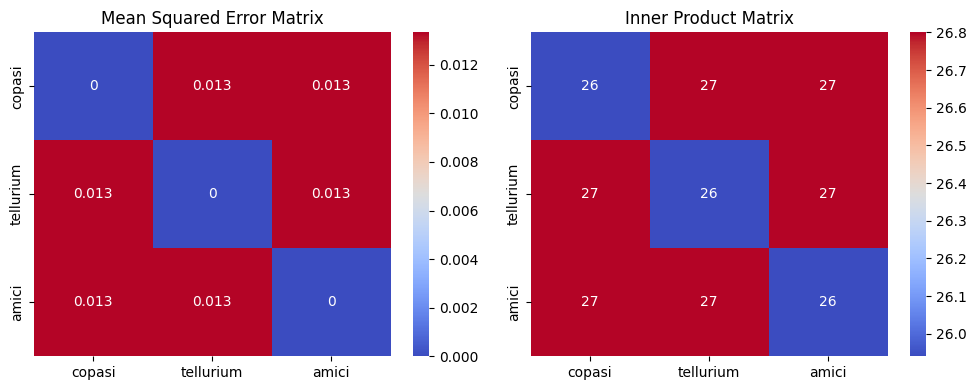

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot MSE matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(mse_df, annot=True, cmap="coolwarm", cbar=True)
plt.title("Mean Squared Error Matrix")

# Plot Inner Product matrix
plt.subplot(1, 2, 2)
sns.heatmap(inner_product_df, annot=True, cmap="coolwarm", cbar=True)
plt.title("Inner Product Matrix")

plt.tight_layout()
plt.show()

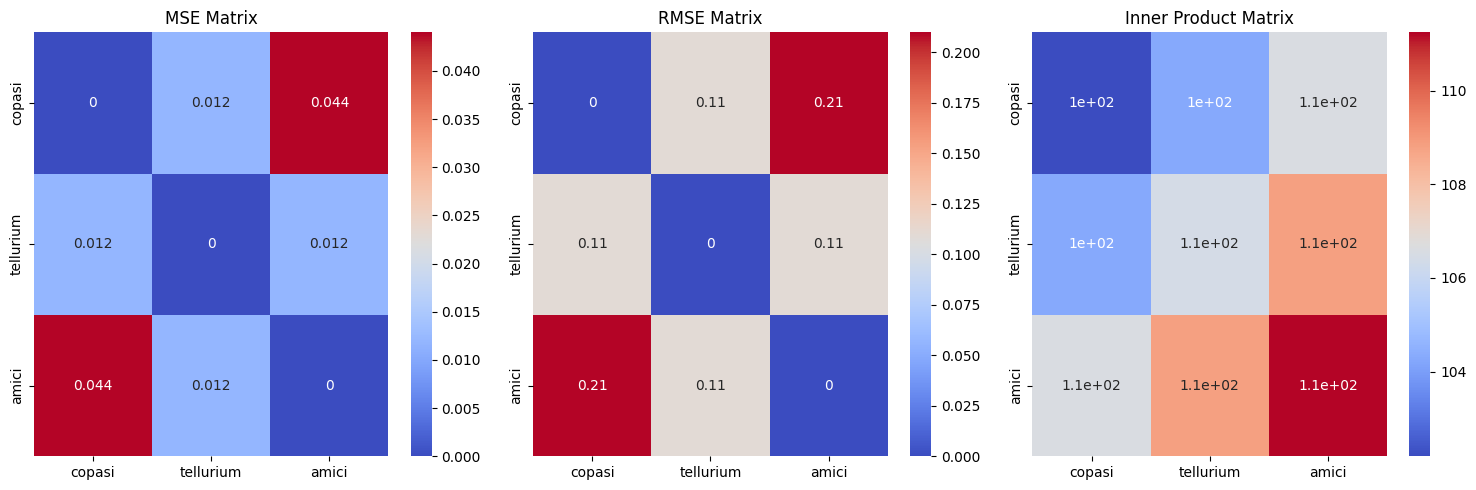

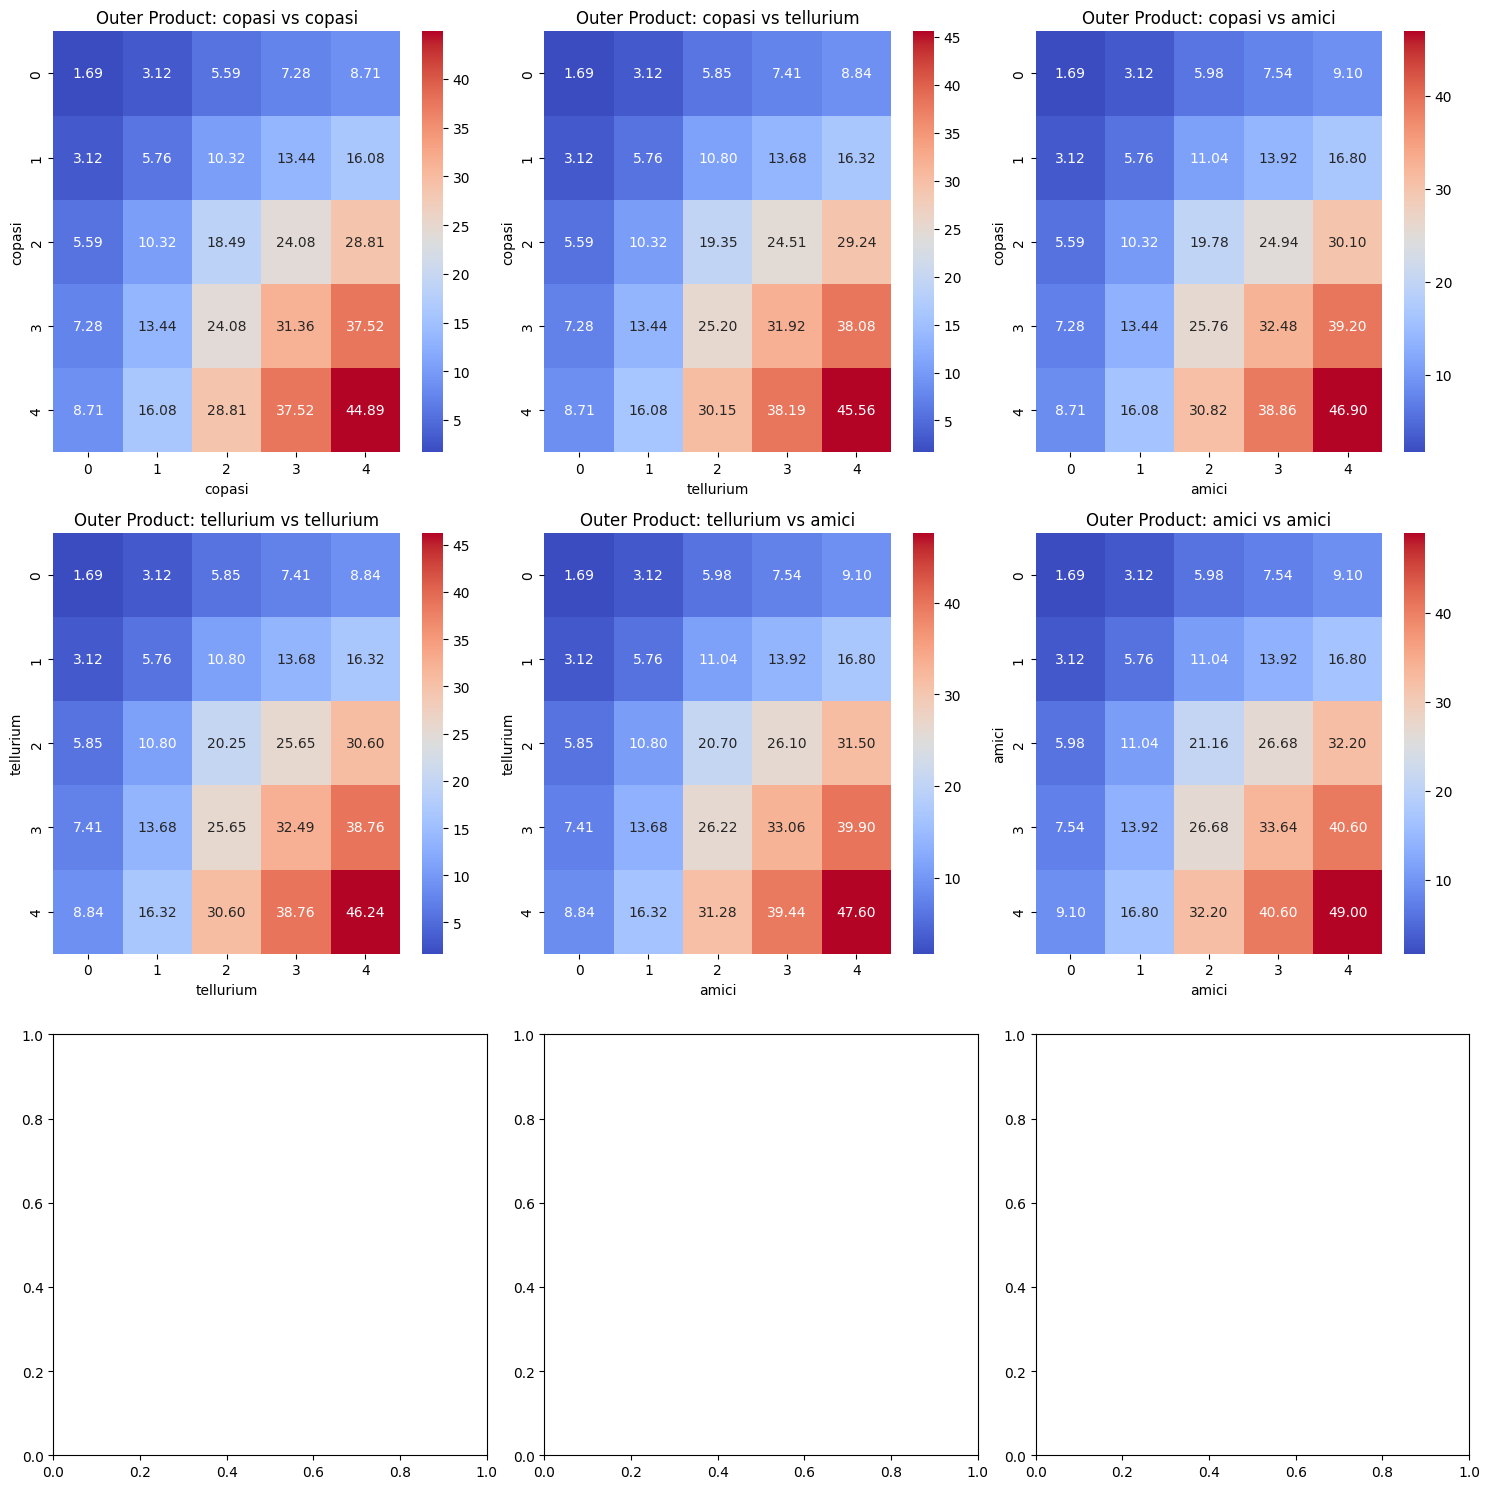

In [31]:
from dataclasses import dataclass
from typing import Dict 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from biosimulator_processes.data_model import _BaseClass


def calculate_mse(a, b):
    return np.mean((a - b) ** 2)

def calculate_rmse(a, b):
    return np.sqrt(calculate_mse(a, b))

def calculate_inner_product(a, b):
    return np.dot(a, b)

def calculate_outer_product(a, b):
    return np.outer(a, b)
    
    
def generate_ode_process_interval_comparison_data(outputs: list[np.array]):
    simulators = ['copasi', 'tellurium', 'amici']
    
    mse_matrix = np.zeros((3, 3), dtype=float)
    rmse_matrix = np.zeros((3, 3), dtype=float)
    inner_product_matrix = np.zeros((3, 3), dtype=float)
    outer_product_matrices = {}
    
    # fill the matrices with the calculated values
    for i in range(len(simulators)):
        for j in range(i, len(simulators)):
            mse_matrix[i, j] = calculate_mse(outputs[i], outputs[j])
            rmse_matrix[i, j] = calculate_rmse(outputs[i], outputs[j])
            inner_product_matrix[i, j] = calculate_inner_product(outputs[i], outputs[j])
            outer_product_matrices[(simulators[i], simulators[j])] = calculate_outer_product(outputs[i], outputs[j])
            if i != j:
                mse_matrix[j, i] = mse_matrix[i, j]
                rmse_matrix[j, i] = rmse_matrix[i, j]
                inner_product_matrix[j, i] = inner_product_matrix[i, j]
    
    # convert matrices to dataframes for better visualization
    mse_df = pd.DataFrame(mse_matrix, index=simulators, columns=simulators)
    rmse_df = pd.DataFrame(rmse_matrix, index=simulators, columns=simulators)
    inner_product_df = pd.DataFrame(inner_product_matrix, index=simulators, columns=simulators)
    return 


def plot_ode_process_comparison(mse_df, rmse_df, inner_product_df):
    # Plot heatmaps for MSE, RMSE, and inner product matrices
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.heatmap(mse_df, annot=True, cmap="coolwarm", cbar=True)
    plt.title("MSE Matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(rmse_df, annot=True, cmap="coolwarm", cbar=True)
    plt.title("RMSE Matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(inner_product_df, annot=True, cmap="coolwarm", cbar=True)
    plt.title("Inner Product Matrix")
    
    plt.tight_layout()
    plt.show()
    
    # Visualize outer product matrices
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for idx, ((sim1, sim2), matrix) in enumerate(outer_product_matrices.items()):
        ax = axes[idx // 3, idx % 3]
        sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, cbar=True)
        ax.set_title(f"Outer Product: {sim1} vs {sim2}")
        ax.set_xlabel(sim2)
        ax.set_ylabel(sim1)
    
    plt.tight_layout()
    plt.show()
    

# Sample time series outputs from three simulators
output_copasi = np.array([1.3, 2.4, 4.3, 5.6, 6.7])
output_tellurium = np.array([1.3, 2.4, 4.5, 5.7, 6.8])
output_amici = np.array([1.3, 2.4, 4.6, 5.8, 7.0])

# List of simulators and their outputs

outputs = [output_copasi, output_tellurium, output_amici]

In [32]:
rmse_df

,copasi,tellurium,amici
copasi,0.000000,0.109545,0.209762
tellurium,0.109545,0.000000,0.109545
amici,0.209762,0.109545,0.000000
